In [1]:
from utils import *

import mne
import json
import numpy as np
import matplotlib as pd
import pandas as pd


In [2]:
SKORUCAK_MAPPING = {"Wake": [0,2,3], "MS": [1]}
with open("splits/skorucack_splits.json") as f:
    splits = json.load(f)

In [3]:
# Authors: Sindri Jónsson 
# Adapted from https://braindecode.org/stable/auto_examples/plot_relative_positioning.html#id5

random_state = 87
n_jobs = 1

In [4]:
import glob
from braindecode.datasets import BaseDataset, BaseConcatDataset
from IPython.display import clear_output

n_sub = 30
ds = []
for path in glob.glob("edf_data/*.edf"):

    # Read edf and add annotations
    file=mne.io.read_raw_edf(path)

    ds.append(BaseDataset(file, description={"subject": path.replace(".edf","")}))
    clear_output()
ds = BaseConcatDataset(ds)

In [5]:
from braindecode.preprocessing.preprocess import preprocess, Preprocessor

# #Pre process data
signal_samp_freq = 100
pp = [Preprocessor("resample", sfreq=signal_samp_freq)]

preprocess(ds, pp) 


In [6]:
from braindecode.preprocessing import create_fixed_length_windows

# Extract windows
win_sec = 1
step_sec = 1
win_samp = int(win_sec * signal_samp_freq)
step_samp = int(step_sec * signal_samp_freq)

# window_samp = int(win_sec*signal_samp_freq)
# window_step = int(step_sec*signal_samp_freq)
# windows_dataset = create_windows_from_events(ds, trial_start_offset_samples=0, trial_stop_offset_samples=0,
#                           window_size_samples=window_samp, window_stride_samples=window_step, preload=True,
#                           mapping = {"W": 0, "MS": 1})

windows_dataset = create_fixed_length_windows(ds, window_size_samples=win_samp, window_stride_samples=step_samp,
                                  drop_last_window=True, preload=True)

In [7]:
# Add labels to windows (1 second signal has the label of the middle 200 ms segment)
# This results in skipping the first and last 2x 200 ms labels
from scipy.io import loadmat

for w in windows_dataset.datasets:
    # _pat = w.description["subject"]
    # _tmp = BernLabels(f"labels/{_pat}.mat", SKORUCAK_MAPPING, include_unilateral=False)
    # _labels, _ = _tmp.apply_rolling_func(win = 0.2, step = 0.2, replace = False)
    # _labels[_labels==0.5] = 1
    # cut = int((len(_labels) - len(w.windows)) / 2)
    mat = loadmat(f"{w.description['subject']}.mat", squeeze_me=True)
    w.y = mat['x']
    w.windows.metadata["target"] = w.y


In [8]:
# Pre process windows
from sklearn.preprocessing import scale as standard_scale

preprocess(windows_dataset, [Preprocessor(standard_scale, channel_wise=True)])

In [9]:
# Splitting dataset into train, valid and test sets

from sklearn.model_selection import train_test_split
from braindecode.datasets import BaseConcatDataset

# subjects = np.unique(windows_dataset.description['subject'])
# subj_train, subj_test = train_test_split(
#     subjects, test_size=0.4, random_state=random_state)
# subj_valid, subj_test = train_test_split(
#     subj_test, test_size=0.5, random_state=random_state)

subj_train, subj_valid = train_test_split(splits["train"], test_size=0.3, random_state=random_state)
subj_test = splits["test"]

class RelativePositioningDataset(BaseConcatDataset):
    """BaseConcatDataset with __getitem__ that expects 2 indices and a target.
    """
    def __init__(self, list_of_ds):
        super().__init__(list_of_ds)
        self.return_pair = True

    def __getitem__(self, index):
        if self.return_pair:
            ind1, ind2, y = index
            return (super().__getitem__(ind1)[0],
                    super().__getitem__(ind2)[0]), y
        else:
            return super().__getitem__(index)

    @property
    def return_pair(self):
        return self._return_pair

    @return_pair.setter
    def return_pair(self, value):
        self._return_pair = value


split_ids = {'train': subj_train, 'valid': subj_valid, 'test': subj_test}
splitted = dict()
for name, values in split_ids.items():
    splitted[name] = RelativePositioningDataset(
        [ds for ds in windows_dataset.datasets
         if ds.description['subject'].split("\\")[-1] in values])

In [10]:
# Creating samplers

from braindecode.samplers import RelativePositioningSampler
n = 1200

tau_pos, tau_neg = int(signal_samp_freq * 3), int(signal_samp_freq * 1 * 60)
n_examples_train = n * len(splitted['train'].datasets)
n_examples_valid = n * len(splitted['valid'].datasets)
n_examples_test = n * len(splitted['test'].datasets)

train_sampler = RelativePositioningSampler(
    splitted['train'].get_metadata(), tau_pos=tau_pos, tau_neg=tau_neg,
    n_examples=n_examples_train, same_rec_neg=True, random_state=random_state)
valid_sampler = RelativePositioningSampler(
    splitted['valid'].get_metadata(), tau_pos=tau_pos, tau_neg=tau_neg,
    n_examples=n_examples_valid, same_rec_neg=True,
    random_state=random_state).presample()
test_sampler = RelativePositioningSampler(
    splitted['test'].get_metadata(), tau_pos=tau_pos, tau_neg=tau_neg,
    n_examples=n_examples_test, same_rec_neg=True,
    random_state=random_state).presample()

In [11]:
# Creating the model
import torch
from torch import nn
from braindecode.util import set_random_seeds
from braindecode.models import SleepStagerChambon2018

device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    torch.backends.cudnn.benchmark = True
# Set random seed to be able to roughly reproduce results
# Note that with cudnn benchmark set to True, GPU indeterminism
# may still make results substantially different between runs.
# To obtain more consistent results at the cost of increased computation time,
# you can set `cudnn_benchmark=False` in `set_random_seeds`
# or remove `torch.backends.cudnn.benchmark = True`
set_random_seeds(seed=random_state, cuda=device == 'cuda')

# Extract number of channels and time steps from dataset
n_channels, input_size_samples = windows_dataset[0][0].shape
emb_size = 32
tcs = 0.25

emb = SleepStagerChambon2018(
    n_channels,
    signal_samp_freq,
    n_classes=emb_size,
    n_conv_chs=16,
    time_conv_size_s=tcs,
    max_pool_size_s=tcs/4,
    input_size_s=input_size_samples / signal_samp_freq,
    dropout=0,
    pad_size_s=tcs/2,
    apply_batch_norm=True
)


class ContrastiveNet(nn.Module):
    """Contrastive module with linear layer on top of siamese embedder.

    Parameters
    ----------
    emb : nn.Module
        Embedder architecture.
    emb_size : int
        Output size of the embedder.
    dropout : float
        Dropout rate applied to the linear layer of the contrastive module.
    """
    def __init__(self, emb, emb_size, dropout=0.5):
        super().__init__()
        self.emb = emb
        self.clf = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(emb_size, 1)
        )

    def forward(self, x):
        x1, x2 = x
        z1, z2 = self.emb(x1), self.emb(x2)
        return self.clf(torch.abs(z1 - z2)).flatten()


model = ContrastiveNet(emb, emb_size, dropout=0.0).to(device)
model.emb.children

c:\Users\SIOS\Anaconda3\lib\site-packages\braindecode\util.py:51: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


<bound method Module.children of SleepStagerChambon2018(
  (spatial_conv): Conv2d(1, 4, kernel_size=(4, 1), stride=(1, 1))
  (feature_extractor): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 25), stride=(1, 1), padding=(0, 13))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(1, 7), stride=(1, 7), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 16, kernel_size=(1, 25), stride=(1, 1), padding=(0, 13))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=(1, 7), stride=(1, 7), padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Dropout(p=0, inplace=False)
    (1): Linear(in_features=128, out_features=32, bias=True)
  )
)>

In [43]:
sum(p.numel() for p in model.emb.parameters())


11044

In [1]:
# _emb = SleepStagerChambon2018(
#     2,
#     128,
#     n_classes=100,
#     n_conv_chs=16,
#     input_size_s= 128*30 / 128,
#     dropout=0,
#     apply_batch_norm=True
# )
# print(sum(p.numel() for p in _emb.parameters()))
# _emb.modules


NameError: name 'emb' is not defined

In [12]:
# Training
import os

from skorch.helper import predefined_split
from skorch.callbacks import Checkpoint, EarlyStopping, EpochScoring
from braindecode import EEGClassifier

lr = 5e-3
batch_size = 256  # 512 if data large enough
n_epochs = 50
num_workers = 0 if n_jobs <= 1 else n_jobs

cp = Checkpoint(dirname='', f_criterion=None, f_optimizer=None, f_history=None)
early_stopping = EarlyStopping(patience=10)
train_acc = EpochScoring(
    scoring='accuracy', on_train=True, name='train_acc', lower_is_better=False)
valid_acc = EpochScoring(
    scoring='accuracy', on_train=False, name='valid_acc',
    lower_is_better=False)
callbacks = [
    ('cp', cp),
    ('patience', early_stopping),
    ('train_acc', train_acc),
    ('valid_acc', valid_acc)
]

clf = EEGClassifier(
    model,
    criterion=torch.nn.BCEWithLogitsLoss,
    
    optimizer=torch.optim.Adam,
    max_epochs=n_epochs,
    iterator_train__shuffle=False,
    iterator_train__sampler=train_sampler,
    iterator_valid__sampler=valid_sampler,
    iterator_train__num_workers=num_workers,
    iterator_valid__num_workers=num_workers,
    train_split=predefined_split(splitted['valid']),
    optimizer__lr=lr,
    batch_size=batch_size,
    callbacks=callbacks,
    device=device
)
# Model training for a specified number of epochs. `y` is None as it is already
# supplied in the dataset.
clf.fit(splitted['train'], y=None)
clf.load_params(checkpoint=cp)  # Load the model with the lowest valid_loss

# os.remove('./params.pt')  # Delete parameters file

  epoch    train_acc    train_loss    valid_acc    valid_loss    cp       dur
-------  -----------  ------------  -----------  ------------  ----  --------
      1       0.5750        0.6698       0.5939        0.6647     +  200.9112
      2       0.6200        0.6455       0.6251        0.6446     +  197.6739
      3       0.6271        0.6390       0.6282        0.6436     +  199.3250
      4       0.6390        0.6299       0.6358        0.6373     +  197.0551
      5       0.6541        0.6179       0.6392        0.6400        197.1911
      6       0.6568        0.6159       0.6448        0.6299     +  198.0016
      7       0.6604        0.6114       0.6484        0.6281     +  197.7153
      8       0.6614        0.6104       0.6461        0.6275     +  197.7796
      9       0.6686        0.6043       0.6489        0.6253     +  197.6612
     10       0.6690        0.6019       0.6567        0.6215     +  198.4547
     11       0.6738        0.5984       0.6600        0.6182   

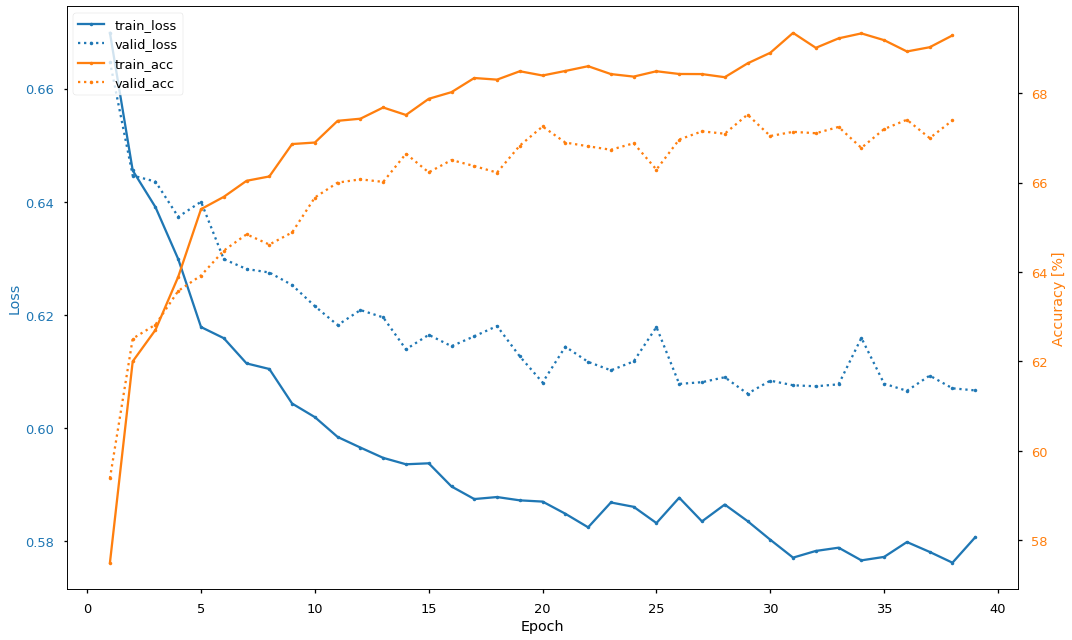

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract loss and balanced accuracy values for plotting from history object
df = pd.DataFrame(clf.history.to_list())

df['train_acc'] *= 100
df['valid_acc'] *= 100

ys1 = ['train_loss', 'valid_loss']
ys2 = ['train_acc', 'valid_acc']
styles = ['-', ':']
markers = ['.', '.']

plt.style.use('seaborn-talk')

fig, ax1 = plt.subplots(figsize=(15, 9))
ax2 = ax1.twinx()
for y1, y2, style, marker in zip(ys1, ys2, styles, markers):
    ax1.plot(df['epoch'], df[y1], ls=style, marker=marker, ms=7,
             c='tab:blue', label=y1)
    ax2.plot(df['epoch'], df[y2], ls=style, marker=marker, ms=7,
             c='tab:orange', label=y2)

ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylabel('Loss', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:orange')
ax2.set_ylabel('Accuracy [%]', color='tab:orange')
ax1.set_xlabel('Epoch')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2)

plt.tight_layout()
plt.show()

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Switch to the test sampler
clf.iterator_valid__sampler = test_sampler
y_pred = clf.forward(splitted['test'], training=False) > 0
y_true = [y for _, _, y in test_sampler]

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

[[ 8295  5463]
 [ 3363 10479]]
              precision    recall  f1-score   support

         0.0       0.71      0.60      0.65     13758
         1.0       0.66      0.76      0.70     13842

    accuracy                           0.68     27600
   macro avg       0.68      0.68      0.68     27600
weighted avg       0.68      0.68      0.68     27600



In [15]:
from torch.utils.data import DataLoader
from sklearn.metrics import balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Extract features with the trained embedder
data = dict()
for name, split in splitted.items():
    split.return_pair = False  # Return single windows
    loader = DataLoader(split, batch_size=batch_size, num_workers=num_workers)
    with torch.no_grad():
        feats = [emb(batch_x.to(device)).cpu().numpy()
                 for batch_x, _, _ in loader]
    data[name] = (np.concatenate(feats), split.get_metadata()['target'].values)

In [38]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the logistic regression model
log_reg = LogisticRegression(
    penalty='l2', C=1.0, class_weight='balanced', solver='lbfgs',
    multi_class='auto', random_state=random_state)

rf = RandomForestClassifier(class_weight='balanced', random_state=random_state)


clf_pipe = make_pipeline(StandardScaler(), log_reg)

# Fit and score the logistic regression
clf_pipe.fit(*data['train'])
train_y_pred = clf_pipe.predict(data['train'][0])
valid_y_pred = clf_pipe.predict(data['valid'][0])
test_y_pred = clf_pipe.predict(data['test'][0])

train_bal_acc = balanced_accuracy_score(data['train'][1], train_y_pred)
valid_bal_acc = balanced_accuracy_score(data['valid'][1], valid_y_pred)
test_bal_acc = balanced_accuracy_score(data['test'][1], test_y_pred)

print('Sleep staging performance with logistic regression:')
print(f'Train bal acc: {train_bal_acc:0.4f}')
print(f'Valid bal acc: {valid_bal_acc:0.4f}')
print(f'Test bal acc: {test_bal_acc:0.4f}')

print('Results on validation set:')
print(confusion_matrix(data['valid'][1], valid_y_pred))
print(classification_report(data['valid'][1], valid_y_pred))

Sleep staging performance with logistic regression:
Train bal acc: 0.8248
Valid bal acc: 0.8682
Test bal acc: 0.8841
Results on validation set:
[[27924  4269]
 [  357  2370]]
              precision    recall  f1-score   support

         0.0       0.99      0.87      0.92     32193
         1.0       0.36      0.87      0.51      2727

    accuracy                           0.87     34920
   macro avg       0.67      0.87      0.71     34920
weighted avg       0.94      0.87      0.89     34920



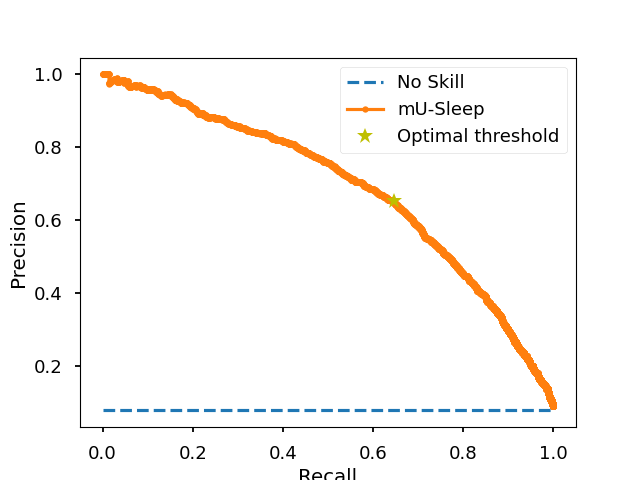

Best Threshold=0.792724, F-Score=0.649


In [39]:
# pr curve for logistic regression model
from sklearn.metrics import precision_recall_curve

valid_y_proba = clf_pipe.predict_proba(data['valid'][0])
valid_y = data['valid'][1]

# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(valid_y, valid_y_proba[:,1])


# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)


# plot the roc curve for the model
no_skill = len(valid_y[valid_y==1]) / len(valid_y)
plt.clf()
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='mU-Sleep')
plt.plot(recall[ix], precision[ix], "y*", markersize=12, label="Optimal threshold")
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

In [40]:
from sklearn.metrics import cohen_kappa_score, f1_score
cohen_kappa_score(train_y_pred, data['train'][1])
cohen_kappa_score(valid_y_pred, data['valid'][1])
yhat = clf_pipe.predict_proba(data['test'][0])[:,1] > thresholds[ix]
cohen_kappa_score(yhat, data['test'][1])

0.6083637073052771

Using matplotlib backend: module://ipympl.backend_nbagg


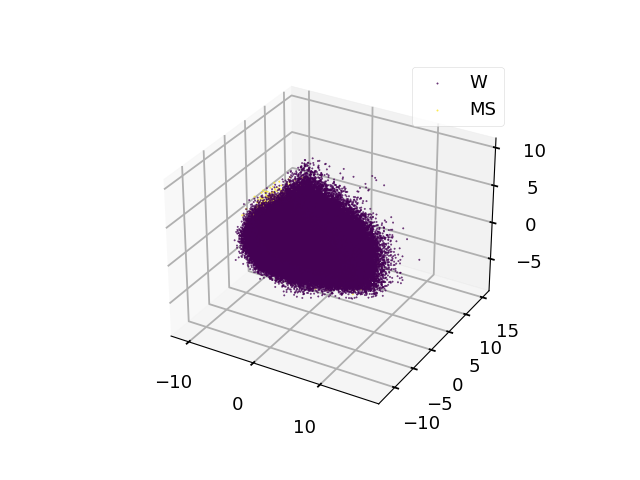

In [41]:
%matplotlib widget
from sklearn.decomposition import PCA
from matplotlib import cm

X = np.concatenate([v[0] for k, v in data.items()])
y = np.concatenate([v[1] for k, v in data.items()])

n = 3

pca = PCA(n_components=n)
#tsne = TSNE(n_components=n)
components = pca.fit_transform(X)

stages = ["W","MS"]
if n != 3:
    fig, ax = plt.subplots()
    colors = cm.get_cmap('viridis', 2)(range(2))
    for i, stage in enumerate(stages):
        mask = y == i
        ax.scatter(components[mask, 0], components[mask, 1], s=3, alpha=0.7,
                   color=colors[i], label=stage)
else:
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    colors = cm.get_cmap('viridis', 2)(range(2))
    for i, stage in enumerate(stages):
        mask = y == i
        ax.scatter(components[mask, 0], components[mask, 1], components[mask, 2],
                   s=1, alpha=0.7, color=colors[i], label=stage)


ax.legend()
plt.show()